In [1]:
#LEARNING TO MIX QISKIT WITH PYTORCH
# https://qiskit.org/textbook/ch-machine-learning/machine-learning-qiskit-pytorch.html

In [2]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function  #will make custom "quantum" activation function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit.visualization import *

In [4]:
#https://stackoverflow.com/questions/43258116/inheriting-a-class-with-the-same-name-in-python
#Answer to Y DIS BE NO GLITCH

class QuantumCircuit:
    
    def __init__(self, n_qubits, backend, shots):
        
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        
        ################################################
        
        self.backend = backend
        self.shots = shots
        
        
    def run(self, thetas):
        job = qiskit.execute(self._circuit, self.backend, shots = self.shots, 
                            parameter_binds = [{self.theta: theta} for theta in thetas]) #NOTE THIS LINE
        result = job.result().get_counts(self._circuit)
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float) #eigenvalues
        
        probabilities = counts / self.shots
        
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation]) #corresponding to thetas
        

< wut > = 0.508


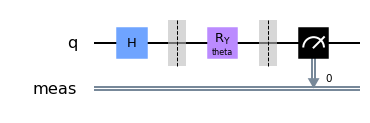

In [5]:
simulator = qiskit.Aer.get_backend('qasm_simulator')
SHOTS = 1000
circuit = QuantumCircuit(1, simulator, SHOTS)
print('< wut > = {}'.format(circuit.run([np.pi])[0]))  #"thetas"
circuit._circuit.draw()

#OKAY SO
# q is randomly 0 or 1 in z-basis, goes in SHOTS times for EACH theta in thetas
# after H it's randomly [1 1] or [1 -1] (normalised)
#Ry pi is [0 -1; 1 0],  eigvec,val
#after Ry pi qubit be [-1 1] or [1 -1] normalised
#expect 0.5 +-


In [17]:
class HybridFunction(Function):  
    
    #Making a custom autograd funciton here, reading this helped
    # https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html
    
    @staticmethod
    def forward(ctx ,input, quantum_circuit, shift):
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        
        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
            
        gradients = np.array([gradients]).T #erm, see the y blah below, need to get the shape right for torch
        return torch.tensor([gradients]).float()*grad_output.float(), None, None

In [7]:
y =[1]
y.append(2)
y

[1, 2]

In [8]:
np.array([y])

array([[1, 2]])

In [9]:
np.array([y]).T

array([[1],
       [2]])

In [10]:
class Hybrid(nn.Module):
    
    def __init__(self, backend, shots, shift):
        #super(Hybrid, self).__init__()  #isn't this a python2 thing?
        super().__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):  #REMEMBER input is a mini-batch, pytorch does mini-batches
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)
        
        

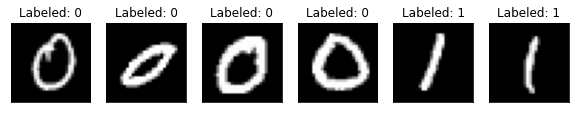

In [11]:
#PASTING BORING PART 


# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples],   #oh neat trick
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [12]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [13]:
class Net(nn.Module):   #this tutorial circuit is definitely overkill
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d() 
        self.fc1 = nn.Linear(256, 64) #https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html
        self.fc2 = nn.Linear(64, 1)  #use that expresssion or a quick 'n dirty blah.flatten.shape
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2) #wtf is that shift value

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

In [18]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Training [5%]	Loss: -0.8039
Training [10%]	Loss: -0.9156
Training [15%]	Loss: -0.9290
Training [20%]	Loss: -0.9323
Training [25%]	Loss: -0.9423
Training [30%]	Loss: -0.9635
Training [35%]	Loss: -0.9581
Training [40%]	Loss: -0.9656
Training [45%]	Loss: -0.9611
Training [50%]	Loss: -0.9694
Training [55%]	Loss: -0.9808
Training [60%]	Loss: -0.9739
Training [65%]	Loss: -0.9745
Training [70%]	Loss: -0.9809
Training [75%]	Loss: -0.9823
Training [80%]	Loss: -0.9842
Training [85%]	Loss: -0.9839
Training [90%]	Loss: -0.9892
Training [95%]	Loss: -0.9867
Training [100%]	Loss: -0.9927


Text(0, 0.5, 'Neg Log Likelihood Loss')

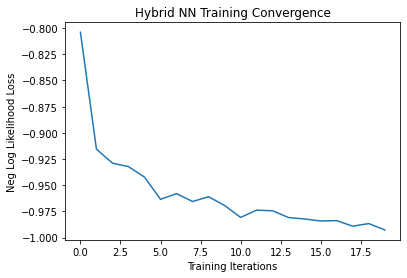

In [19]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

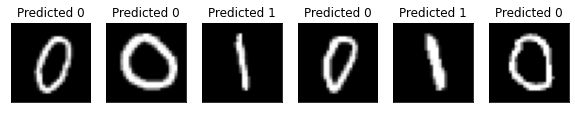

In [20]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1